In [90]:
import h5py
import numpy as np
import os
import sys
import scipy.io as sio
sys.path.append('/Users/yixuan/Documents/GitHub/pybmi')
from pybmi.utils.ZTools import ZStructTranslator, zarray
from pybmi.utils import ZTools, spikePlot_JC, AnalysisTools
from pybmi.utils.ZTools import ZStructTranslator,zarray
from pybmi.utils.AnalysisTools import calcBitRate

import matplotlib.pyplot as plt
%matplotlib notebook

import pandas as pd
pd.options.display.max_columns = None

from ipywidgets import Text, IntSlider, VBox, HBox, Button, RadioButtons, Textarea, Output
from IPython.display import display, clear_output

import pickle
import math
import time

### Functions in this notebook and what they do:

* **loadDay(current_day)**:
    * gets the date, runs, and note from the day and runs all following functions
    
* **loadDay()**:
    * Loads the runs in a day, checks if there's any potential runs, if not, move on to next day
    
* **loadRun(run, loadingPath, monkey, binsize, cutoff, remove)**:
    * Loops in loadDay. Loads the zStruct for the day, check target style and number of trials
    * Calls getRunFeats to get feats and start plotting

* **initialize_plot()**:
    * initialize the structure of the plot and the widgets
    
* **clearCache()**:
    * Part of loadDay. Clears the global cache dictionary to store data from the day for use in other functions.
    * Reset the flags and global variables to initiate the day  
  
* **getRunFeats(combinedZ_TS, runsLoaded_TS, binsize)**:
    * Retrieve the feats for a selected run, gets trial number, trial indices, min and max indices, etc.  
      
* **plotNeuralFinger(run, feats, TrialStart, TrialNumber, binsize, start, minIndex, maxIndex, lineSeperation, widgets)**:
    * Part of getRunFeats. Uses matplotlib and ipywidgets generate the actual plot and widget for 5 trials in run  
    
* **interactiveTrialPlot(run, feats, TrialStart, TrialNumber, binsize, start, minIndex, maxIndex, lineSeperation)**:
    * Create interactive widgets and callbacks to select run and trials to plot  
      
* **saving_notes(monkey, savingPath, runs_dict)**: 
    * Once have a dictionary of good runs and bad runs, save the dictionary out as a csv  
      
* **saveCleanedDay(combinedZ_TS, binsize, date, monkey, savingPath, good_runs_local, good_trials_in_runs)**:
    * Picks out the the good runs from the days and get 400 trials total, saves feats out as a pkl  
      
* **savingFeats(zStruct, binsize, date, run, TS, monkey, savingPath)**:
    * A part of saveCleanedDay. The actual code that does saves the processed feats out as a pkl

In [2]:
# Loading csv

import datetime

datesruns = pd.read_csv('/Volumes/share/Student Folders/Bianca_Wang/firstpass_datesruns.csv', encoding = 'Windows-1252')
datesruns['Date'] = pd.to_datetime(datesruns['Date'], format='%m/%d/%Y')
datesruns['Date'] = datesruns['Date'].dt.strftime('%Y-%m-%d')
datesruns['Runs'] = datesruns['Runs'].apply(lambda x: [int(i.strip()) for i in x.split(',')])

In [148]:
def get_day(current_day):
    global date, runs, note
    date = datesruns.loc[current_day, 'Date']
    runs = datesruns.loc[current_day, 'Runs']
    note = datesruns.loc[current_day, 'Notes']
    loadDay()

### ONLY RUN THIS BLOCK AFTER RUNNING CELLS BELOW

Saving pkl and note file
No trials for Empty DataFrame
Columns: []
Index: []
Not enough good trials to save, only have 0 trials.
Plotting next run in loop...
Loading 2020-02-05
Run-003
Loading previous .mat Z Struct...
Finished Loading previous .mat Z Struct
Enought trials for TS34, number of trials: 387, retrieve feats and plot


/var/folders/01/rdw6t6nn2pxbmk540h3qc_x80000gn/T/ipykernel_13968/1222485732.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z['TargetPosStyle'] = z['TargetPosStyle'].astype(int).astype(str)
/var/folders/01/rdw6t6nn2pxbmk540h3qc_x80000gn/T/ipykernel_13968/1222485732.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z['Run'] = run


<IPython.core.display.Javascript object>


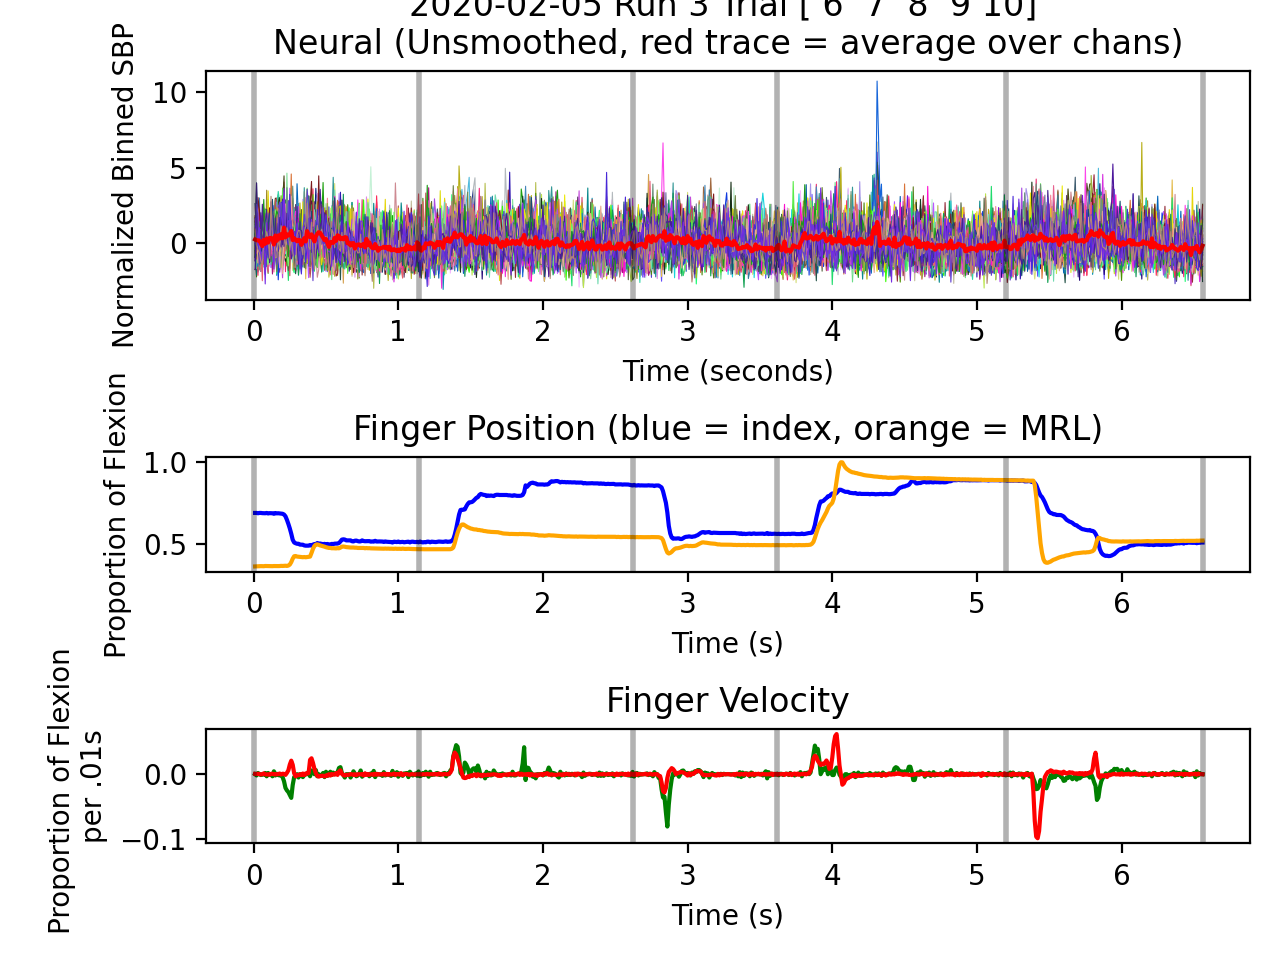

Output()

Potential runs:  [3]
Notes on 2020-02-05: nan
Loaded all runs from 2020-02-05, but only have 0 trials for TS29.


In [157]:
plotted = False
get_day(current_day)

<IPython.core.display.Javascript object>


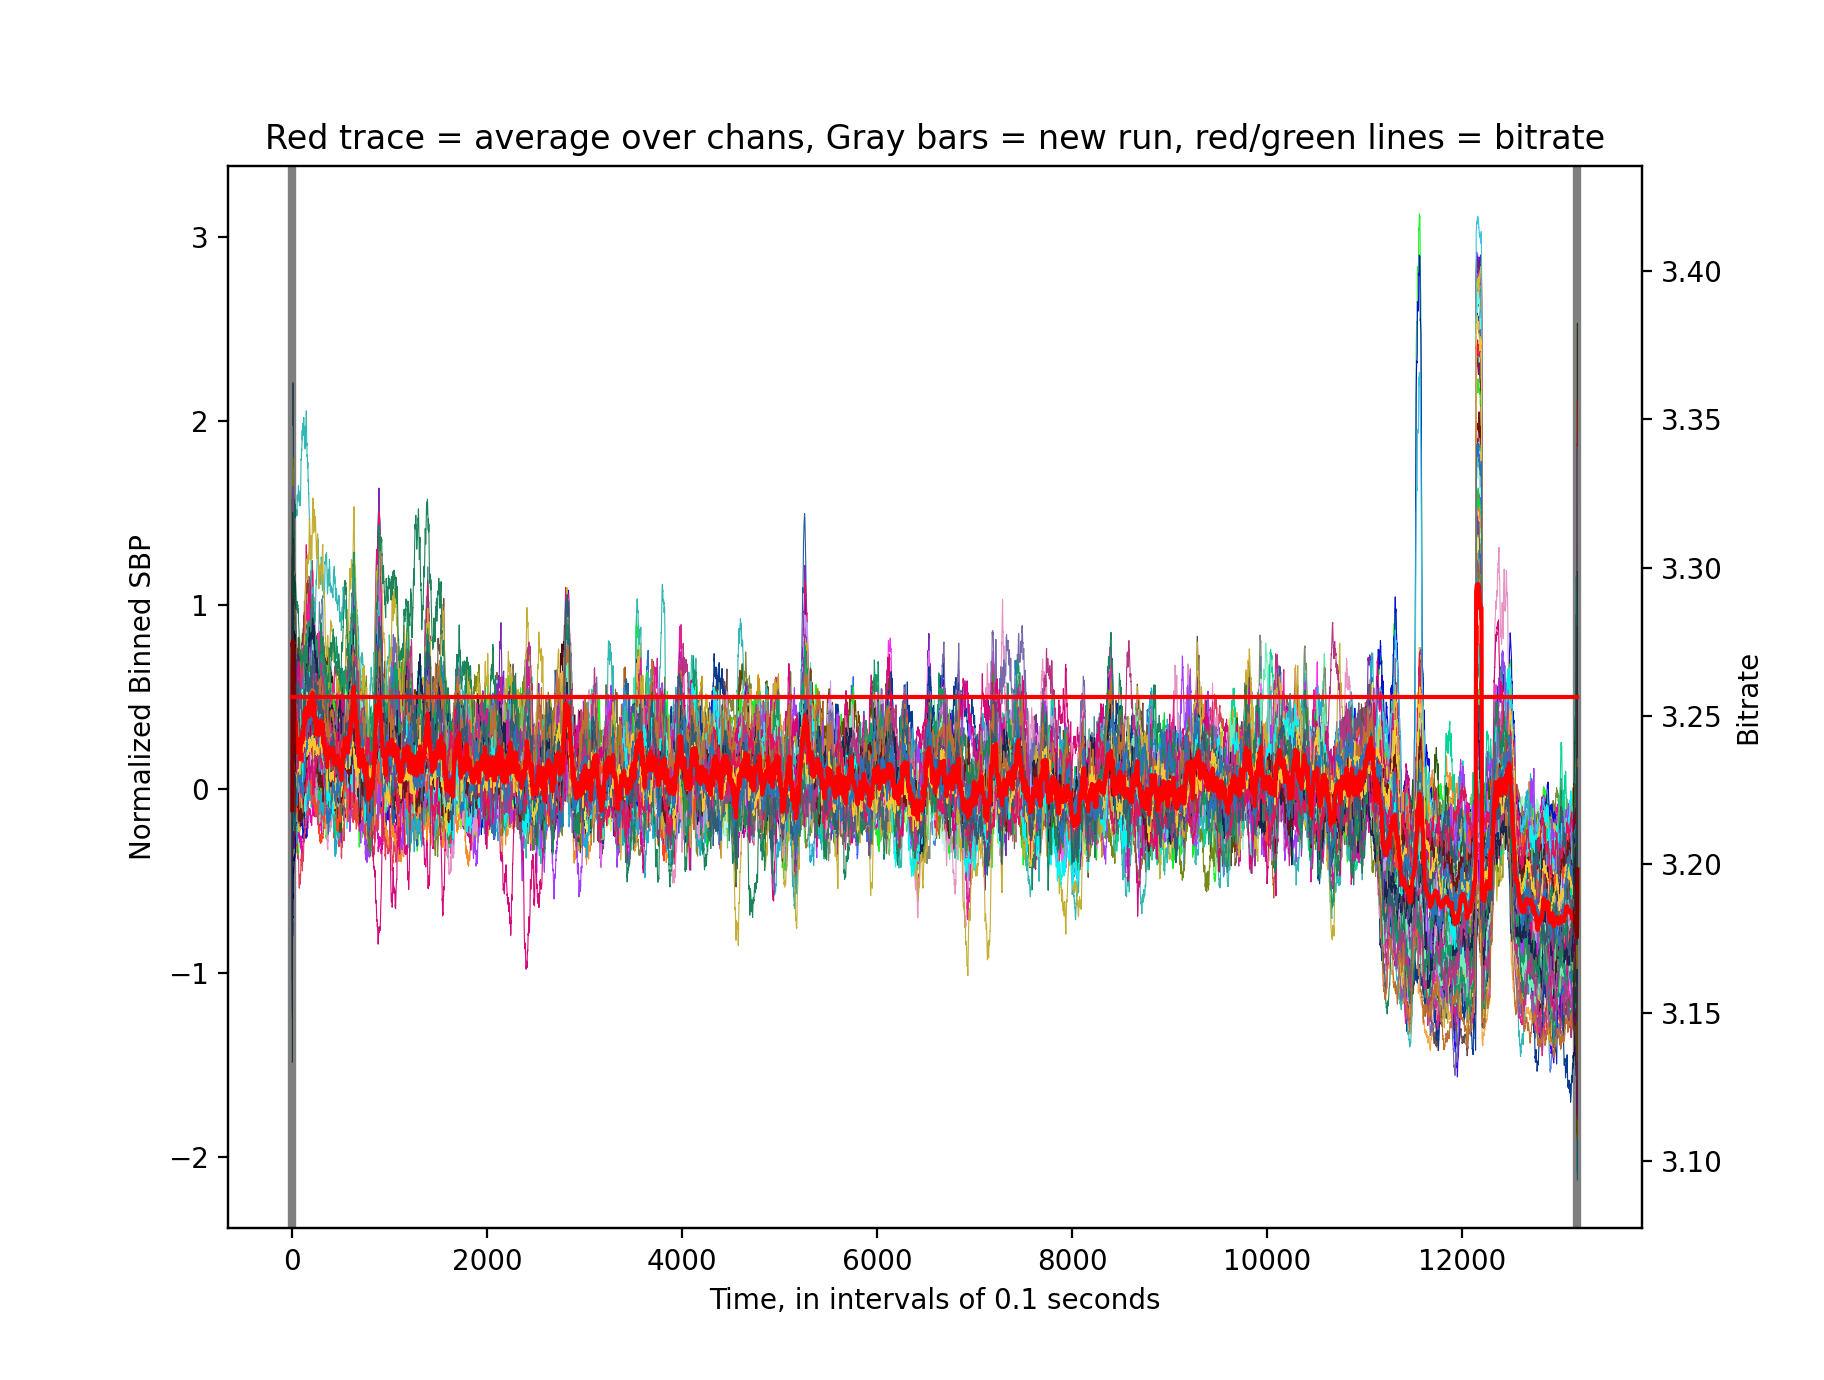

In [22]:
# if you want to take a look at the runs overall, run AFTER running loadDay
spikePlot_JC.spikePlot_JC(cache['zcell'], 100, goodChans, 0)

## RUN ALL THE CELLS BELOW *BEFORE* RUNNING get_day

In [3]:
good_runs = {'Date': [],
            'Run': [],
            'Note': []}

bad_runs = {'Date': [],
            'Run': [],
           'Note': []}

In [129]:
# Parameters & global variables
binsize = 10
goodChans = list(range(1, 97))
goodChans_indexed = [chan - 1 for chan in goodChans]
cutoff = 400
remove = 5

monkey = 'Joker'
loadingPath = '/Volumes/share/Data/Monkeys' # the path to the server Monkeys folder
savingPath = '/Volumes/share/Student Folders/Bianca_Wang/test'

date = ''
runs = []
note = ''

plotted = False

terminate_flag = False
next_run_flag = True
current_run = 0
current_day = 0
TS_list = []
good_trials_in_runs = []
runs_loaded = []

good_runs_local = []
bad_runs_local = []

neural_data = []
finger_position = []
finger_velocity = []
line_seperations = []
average_line = [] 

cache = {'combinedZ29': pd.DataFrame(), 
         'combinedZ34': pd.DataFrame(), 
         'saving_df': [],
         'zcell': []} # stores the data for the day only, clears when loading the next day

In [143]:
# BUTTONS AND WIDGETS

def terminate_plotting(b):
    global terminate_flag
    terminate_flag = True
    clear_output()
    print("Plotting terminated.")
    
    # Save pkl files for each TS seperately
    saveCleanedDay(cache['combinedZ29'], 32, date, monkey, savingPath, good_runs_local, good_trials_in_runs)
    saveCleanedDay(cache['combinedZ34'], 32, date, monkey, savingPath, good_runs_local, good_trials_in_runs)
    # Save the good/bad runs note dictionary
    saving_notes(monkey, savingPath, good_runs)
    saving_notes(monkey, savingPath, bad_runs)

# Terminate button
terminate_button = Button(description='Terminate Plotting', button_style='danger')
terminate_button.on_click(terminate_plotting)

def plot_next_run(b):
    global next_run_flag, current_run, current_day, plotted
    next_run_flag = True
    if current_run < len(runs_loaded)-1:
        print("Plotting next run in loop...")
        current_run += 1 
        getRunFeats(binsize, cache['combinedZ29'], cache['combinedZ34'])
    else:
        if current_day < datesruns.shape[0]-1:
            clear_output(wait=True)
            plotted = False
            print("This is already the last run of the day.")
            print('Saving pkl and note file for the day')
            # Save pkl files for each TS seperately
            saveCleanedDay(cache['combinedZ29'], 32, date, monkey, savingPath, good_runs_local, good_trials_in_runs)
            saveCleanedDay(cache['combinedZ34'], 32, date, monkey, savingPath, good_runs_local, good_trials_in_runs)
            # Save the good/bad runs note dictionary
            saving_notes(monkey, savingPath, good_runs)
            saving_notes(monkey, savingPath, bad_runs)
            # load the next day
            current_day += 1
            print("Plotting next run in loop...")
            get_day(current_day)
        else:
            print("This is already the last day.")

# Next run button
next_run_button = Button(description='Next Run →', button_style='success')
next_run_button.on_click(plot_next_run)

def plot_previous_run(b):
    global current_run, current_day
    global next_run_flag
    
    next_run_flag = True
    if current_run > 0:
        print("Plotting previous run in loop...")
        current_run -= 1 
        getRunFeats(binsize, cache['combinedZ29'], cache['combinedZ34'])
    else:
        print("This is already the first run of the day.")

# Previous run button
previous_run_button = Button(description='← Previous Run')
previous_run_button.on_click(plot_previous_run)


# Trial slider
start_trial_input = IntSlider(min=0, 
                              max=10, 
                              step=5, 
                              value=0, 
                              description='Start: ')

# Function to update the slider with new data
def update_slider(minIndex, maxIndex, start):
    start_trial_input.min = minIndex
    start_trial_input.max = maxIndex
    start_trial_input.value = start
    start_trial_input.step = 5

# Radio buttons for marking good/bad run
run_classification = RadioButtons(
    options=[('good', 'good'), ('bad', 'bad')],
    description='Run Classification:',
    disabled=False
)

# Text box for note
note_input = Textarea(
    value='',
    placeholder='Enter note for the run (optional)',
    description='Note:',
    disabled=False
)

# Arrows to move 5 trials forward/backward
left_trial_button = Button(description='←')
right_trial_button = Button(description='→')

# Button callback functions for trials
def decrement_trial_slider(b):
    if start_trial_input.value > start_trial_input.min:
        start_trial_input.value -= start_trial_input.step

def increment_trial_slider(b):
    if start_trial_input.value < start_trial_input.max - 5:
        start_trial_input.value += start_trial_input.step
    else: start_trial_input.value += ((start_trial_input.max) - start_trial_input.value)

# Connect buttons to their actions
left_trial_button.on_click(decrement_trial_slider)
right_trial_button.on_click(increment_trial_slider)

# Button to save note and classification
confirm_button = Button(description='Confirm', button_style='primary')

def plot_next_day(b):
    global current_day, plotted
    
    if current_day < datesruns.shape[0]-1:   
        clear_output(wait=True)
        plotted = False
        print('Saving pkl and note file')
        # Save pkl files for each TS seperately
        saveCleanedDay(cache['combinedZ29'], 32, date, monkey, savingPath, good_runs_local, good_trials_in_runs)
        saveCleanedDay(cache['combinedZ34'], 32, date, monkey, savingPath, good_runs_local, good_trials_in_runs)
        # Save the good/bad runs note dictionary
        saving_notes(monkey, savingPath, good_runs)
        saving_notes(monkey, savingPath, bad_runs)
        # load the next day
        current_day += 1
        print("Plotting next run in loop...")
        get_day(current_day) 
    else:
        print("This is already the last day.")

# Next day button
next_day_button = Button(description='NEXT DAY & SAVE', 
                         button_style = 'info')
next_day_button.on_click(plot_next_day)

# Previous day button
def plot_previous_day(b):
    global current_day, plotted
    
    if current_day > 0:
        clear_output(wait=True)
        plotted = False
        print('Saving pkl and note file')
        # Save pkl files for each TS seperately
        saveCleanedDay(cache['combinedZ29'], 32, date, monkey, savingPath, good_runs_local, good_trials_in_runs)
        saveCleanedDay(cache['combinedZ34'], 32, date, monkey, savingPath, good_runs_local, good_trials_in_runs)
        # Save the good/bad runs note dictionary
        saving_notes(monkey, savingPath, good_runs)
        saving_notes(monkey, savingPath, bad_runs)
        # load the next day
        current_day -= 1
        print("Plotting next run in loop...")
        get_day(current_day)
    
    else:
        print("This is already the first day.")

# Next day button
previous_day_button = Button(description='PREV DAY & SAVE')
previous_day_button.on_click(plot_previous_day)

output_area = Output()

In [100]:
def initialize_plot():

    colorList = ['blue', 'orange']
    colorList2 = ['green', 'red']
   
    # Initialize Neural lines
    for i in range(96):
        line, = ax[0].plot([], [], linewidth=0.4, color=[np.random.rand(), np.random.rand(), np.random.rand()])
        neural_data.append(line)
    avg_line, = ax[0].plot([], [], color='red', linewidth=1.5)
    average_line.append(avg_line)
    
    ax[0].set(xlabel='Time (seconds)', ylabel='Normalized Binned SBP', 
              title='Neural (Unsmoothed, red trace = average over chans)')
    
    # Initialize Finger lines
    for i in range(2):
        line_pos, = ax[1].plot([], [], color=colorList[i])
        finger_position.append(line_pos)
        line_vel, = ax[2].plot([], [], color=colorList2[i])
        finger_velocity.append(line_vel)
        
    ax[1].set(xlabel='Time (s)', ylabel='Proportion of Flexion', 
              title='Finger Position (blue = index, orange = MRL)')
    ax[2].set(xlabel='Time (s)', ylabel='Proportion of Flexion \nper .01s',
              title='Finger Velocity')
    
    # Initialize line seperations
    for _ in range(6):
        for i in range(3):
            line_sep = ax[i].axvline(x=0, color='black', linewidth=2, alpha=0.3)
            line_seperations.append(line_sep)
    
    plt.tight_layout()
    plt.show()
    
    # Display the widgets and buttons
    display(HBox([left_trial_button, start_trial_input, right_trial_button]))
    display(HBox([run_classification, note_input, confirm_button]))
    display(HBox([previous_run_button, next_run_button]))
    display(HBox([previous_day_button, next_day_button, terminate_button]))
    display(output_area)

In [111]:
def clearCache():
    global terminate_flag, next_run_flag, current_run, good_runs_local, bad_runs_local, cache, good_trials_in_runs, TS_list, plotted, runs_loaded
    
    cache = {'combinedZ29': pd.DataFrame(), 
             'combinedZ34': pd.DataFrame(), 
             'saving_df': [],
             'zcell': []}

    terminate_flag = False
    next_run_flag = True
    current_run = 0
    good_runs_local = []
    bad_runs_local = []
    good_trials_in_runs = []
    TS_list = []
    runs_loaded = []
    output_area.clear_output(wait=True)

In [123]:
def loadRun(run, loadingPath, monkey, binsize, cutoff, remove):
    
    global cache, TS_list, current_day, plotted, runs_loaded, fig2, ax, neural_data, finger_position, finger_velocity, line_seperations, average_line
    
    combinedZ29 = cache['combinedZ29']
    combinedZ34 = cache['combinedZ34']
    
    run_str = f'Run-{str(run).zfill(3)}'
    print(run_str)
    fpath = os.path.join(loadingPath, monkey, date, run_str)
    z = ZStructTranslator(fpath, use_py=False).asdataframe()
    cache['zcell'].append(z)
    z = z[remove:] # Takes out the first few trials
    z['TargetPosStyle'] = z['TargetPosStyle'].astype(int).astype(str)      
    z['Run'] = run

    TS = z['TargetPosStyle'].mode()[0]
    TS_list.append(TS)

    if TS == '29': 
        Z29 = z[(z['TargetPosStyle'] == TS) & 
              (z['ClosedLoop'] == 0) & 
              (z['TrialSuccess'] == 1)]
        combinedZ29 = pd.concat([combinedZ29, Z29], ignore_index = True)
        runs_loaded.append(run)

    elif TS == '34':
        Z34 = z[(z['TargetPosStyle'] == TS) & 
              (z['ClosedLoop'] == 0) & 
              (z['TrialSuccess'] == 1)]
        combinedZ34 = pd.concat([combinedZ34, Z34], ignore_index = True)
        runs_loaded.append(run)

    elif TS != '29' and TS != '34':
        print(f'Not the correct target style, the target style is actually {TS}.')

    if combinedZ29.shape[0] >= 350:
        print(f"Enought trials for TS29, number of trials: {combinedZ29.shape[0]}, retrieve feats and plot")
        if not plotted:
            neural_data, finger_position, finger_velocity, line_seperations, average_line = [], [], [], [], []
            fig2, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2, 1, 1]})
            initialize_plot()
            plotted = True
        getRunFeats(binsize, combinedZ29, combinedZ34)

    if combinedZ34.shape[0] >= 350:
        print(f"Enought trials for TS34, number of trials: {len(combinedZ34['TrialNumber'])}, retrieve feats and plot")
        if not plotted:
            neural_data, finger_position, finger_velocity, line_seperations, average_line = [], [], [], [], []
            fig2, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2, 1, 1]})
            initialize_plot()
            plotted = True
        getRunFeats(binsize, combinedZ29, combinedZ34)
    
    cache['combinedZ29'] = combinedZ29
    cache['combinedZ34'] = combinedZ34

In [151]:
def loadDay():

    """
    loadingPath: the path to the server Monkeys folder
    monkey: takes a string, e.g. "Joker"
    binsize: how to bin the data in milliseconds
    cutoff: minimum number of trials acceptable
    remove: how many trials to remove from the beginning of the run
    
    Reads in the run numbers for the day as a list of integers
    Reads in the note for the day
    Loads the first run for the day with ZStructTranslator
    Takes out the first 5 trials and unsuccessful trials
    Checks target style and if trials ≥ cutoff
    If trials ≥ cutoff, use getZFeats to get neural, finger, trial number, target style
    if trials < cutoff, load the next run, do the same stuff and append
    """
    clearCache()
    
    global cache, current_day
    
    print(f"Loading {date}")
        
    for run in runs:
        loadRun(run, loadingPath, monkey, binsize, cutoff, remove)
        
    if cache['combinedZ29'].shape[0] < 350 and cache['combinedZ34'].shape[0] < 350:
        current_day += 1
        print(f"Loaded all runs from {date}, no TS 29/34, loading the next day: {datesruns.loc[current_day, 'Date']}")
        get_day(current_day)
        
    elif cache['combinedZ29'].shape[0] < 350:
        print(f"Loaded all runs from {date}, but only have {cache['combinedZ29'].shape[0]} trials for TS29.")
        
    elif cache['combinedZ34'].shape[0] < 350:
        print(f"Loaded all runs from {date}, but only have {cache['combinedZ34'].shape[0]} trials for TS34.")

In [130]:
def getRunFeats(binsize, combinedZ29, combinedZ34):
    """
    global fig2, ax, neural_data, finger_position, finger_velocity, line_seperations, average_line, plotted, runs_loaded
    
    neural_data, finger_position, finger_velocity, line_seperations, average_line = [], [], [], [], []
    fig2, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2, 1, 1]})
    initialize_plot()
    plotted = True
    """
    
    global current_run
    
    run = runs_loaded[current_run]
    TS = TS_list[current_run]
    
    if TS == '29':
        zRun = combinedZ29[combinedZ29['Run'] == run].reset_index(drop=True)
    elif TS == '34': 
        zRun = combinedZ34[combinedZ34['Run'] == run].reset_index(drop=True)

    feats = ZTools.getZFeats(zRun, binsize,
                             featList=('FingerAnglesTIMRL', 'NeuralFeature', 'TrialNumber'),
                             trimBlankTrials=False, removeFirstTrial=False)

    TrialNumber, TrialStart, TrialCount = np.unique(feats["TrialNumber"], return_index=True, return_counts=True)
    lineSeperation = np.append(TrialStart, TrialStart[-1] + TrialCount[-1]) * (10 / 1000)
    minIndex = 0
    maxIndex = len(TrialNumber) - 1

    while next_run_flag:
        interactiveTrialPlot(run, feats, TrialStart, TrialNumber, binsize, minIndex, minIndex, maxIndex, lineSeperation, TS)

In [132]:
# new code for only updating the data

def plotNeuralFinger(run, feats, TrialStart, TrialNumber, binsize, start, minIndex, maxIndex, lineSeperation, TS):

    global terminate_flag
    global next_run_flag
    next_run_flag = False

    start = start if start < maxIndex else maxIndex - 1
    startIndex = TrialStart[start]
    end = start + 5
    endIndex = TrialStart[end] if end < maxIndex else None
    trialsList = TrialNumber[start:end]
    
    Neural = np.abs(feats['NeuralFeature'][startIndex:endIndex])
    Neural = (Neural - np.mean(Neural, axis=0)) / np.std(Neural, axis=0)
    Finger = feats['FingerAnglesTIMRL'][startIndex:endIndex, (1, 3, 6, 8)]

    lineSeperation = lineSeperation[start:end+1]
    lineSeperation = [x - lineSeperation[0] for x in lineSeperation]
    while len(lineSeperation) < 6:
        lineSeperation.append(0)
    
    # Update neural data
    for i, line in enumerate(neural_data):
        line.set_data(np.arange(1, Neural.shape[0] + 1) * (10 / 1000), Neural[:, i])
    
    # Update plot title
    ax[0].set(xlabel = 'Time (seconds)', ylabel = 'Normalized Binned SBP', 
              title = f'{date} Run {run} Trial {trialsList} \nNeural (Unsmoothed, red trace = average over chans)')

    # Update average line
    average_spike = np.mean(Neural, axis=1)
    average_line[0].set_data(np.arange(1, Neural.shape[0] + 1) * (10 / 1000), average_spike)
    
    # Update finger position
    for i, line in enumerate(finger_position):
        line.set_data(np.arange(1, Finger.shape[0] + 1) * (10 / 1000), Finger[:, i])
            
    # Update finger velocity
    for i, line in enumerate(finger_velocity):
        line.set_data(np.arange(1, Finger.shape[0] + 1) * (10 / 1000), Finger[:, i + 2])
            
    
    # Update line seperations
    for i in range(3):  # Iterate over subplots
        for j, line in enumerate(line_seperations[i::3]):  # Step by 3 to address each subplot
            line.set_xdata([lineSeperation[j]])

    
    # Adjust axis limits
    for a in ax:
        a.relim()
        a.autoscale_view()
    
    fig2.canvas.draw_idle()
    
    #return good_runs_local, bad_runs_local

In [93]:
def interactiveTrialPlot(run, feats, TrialStart, TrialNumber, binsize, start, minIndex, maxIndex, lineSeperation, TS):

    # update the trial slider with data
    update_slider(minIndex, maxIndex, start)
    
    # Define the update function
    def update_plot(change):
        global terminate_flag
        terminate_flag = False
        global next_run_flag

        new_start = change['new']
        plotNeuralFinger(run, feats, TrialStart, TrialNumber, binsize, new_start, minIndex, maxIndex, lineSeperation, TS)
        
    # Save the classification and note
    def save_classification(change):
        global good_runs, bad_runs, date, runs, trial_count, good_trials_in_runs, runs_loaded
        classification = run_classification.value
        note = note_input.value if note_input.value else ' '
        run = runs_loaded[current_run]
        
        # Function to remove an entry from the dictionaries
        def remove_entry(runs_dict, runs_local, run, date):
            if run in runs_dict['Run'] and date in runs_dict['Date']:
                indices = [i for i, (r, d) in enumerate(zip(runs_dict['Run'], runs_dict['Date'])) if r == run and d == date]
                for index in sorted(indices, reverse=True):
                    runs_dict['Date'].pop(index)
                    runs_dict['Run'].pop(index)
                    runs_dict['Note'].pop(index)
            if run in runs_local and len(runs_local) > 0 and len(good_trials_in_runs) > 0:
                index = runs_local.index(run)
                runs_local.remove(run)
                good_trials_in_runs.pop(index)
            
        # Remove run from good_runs if it exists with the same date
        remove_entry(good_runs, good_runs_local, run, date)

        # Remove run from bad_runs if it exists with the same date
        remove_entry(bad_runs, bad_runs_local, run, date)

        if classification == 'good':
            good_runs['Date'].append(date)
            good_runs['Run'].append(run)
            good_runs['Note'].append(note)
            good_runs_local.append(run)
            good_trials_in_runs.append(len(TrialNumber))
        elif classification == 'bad':
            bad_runs['Date'].append(date)
            bad_runs['Run'].append(run)
            bad_runs['Note'].append(note)
            bad_runs_local.append(run)

        with output_area:
            output_area.clear_output(wait=True)
            print("Good Runs in the day:", good_runs_local)
            print("Bad Runs in the day:", bad_runs_local)
            print("Total number of good trials from the day:", sum(good_trials_in_runs))
            print("Good trials by runs:", good_trials_in_runs)

    # Add observers
    start_trial_input.observe(update_plot, names='value')
    #run_classification.observe(save_classification, names='value')
    confirm_button.on_click(save_classification)

    # Initial plot
    update_plot({'new': start_trial_input.value})
    
    print('Potential runs: ', runs)
    print(f"Notes on {date}: {note}")
    
    #return good_runs_local, bad_runs_local, good_trials_in_runs

In [14]:
def savingFeats(zStruct, binsize, date, run, TS, monkey, savingPath):
    
    compiled = {
    "Date": [],
    "Run": [],
    "Target Style": [],
    "TrialNumber": [],
    "TrialIndex": [],
    "TargetPos": [],
    "FingerAnglesTIMRL": [],
    "NeuralFeature": [],
    "TrialLength": []
    }
    
    feats = ZTools.getZFeats(zStruct, binsize, 
                             featList=('FingerAnglesTIMRL','NeuralFeature',
                                       'TrialNumber','TargetPos'))
    TrialNumber, TrialIndex, TrialLength = np.unique(feats["TrialNumber"], return_index=True, return_counts=True)
    FingerAngles = feats["FingerAnglesTIMRL"][:, (1, 3, 6, 8)]  #selecting only position and velocity

    compiled["Date"] = date
    compiled["Run"] = run
    compiled["Target Style"] = TS
    compiled["TrialNumber"] = TrialNumber
    compiled["TrialIndex"] = TrialIndex
    compiled["TrialLength"] = TrialLength
    compiled["TargetPos"] = feats["TargetPos"][TrialIndex]
    compiled["FingerAnglesTIMRL"] = FingerAngles
    compiled["NeuralFeature"] = feats["NeuralFeature"]

    filename = f'{monkey}_{date}_Run{run}_TS{TS}.pkl'
    with open(os.path.join(savingPath, filename),'wb') as f:
        pickle.dump(compiled, f)

In [138]:
def saveCleanedDay(combinedZ_TS, binsize, date, monkey, savingPath, good_runs_local, good_trials_in_runs):
    
    global cache
    feats_saved = False
    trials_to_go = cutoff
    saving_df = pd.DataFrame()
    if combinedZ_TS.empty:
        print("No trials for", combinedZ_TS)
        return
    else: 
        combinedZ_TS = combinedZ_TS[combinedZ_TS['Run'].isin(good_runs_local)].reset_index(drop=True)
    all_trials = combinedZ_TS.shape[0]
    if not combinedZ_TS.empty:
        TS = combinedZ_TS['TargetPosStyle'].mode()[0]
    
    global cache
    
    if len(good_runs_local) == 1:
        if 350 <= combinedZ_TS.shape[0] <= cutoff:
            savingFeats(combinedZ_TS, 32, date, good_runs_local[0], TS, monkey, savingPath)
            print("Feats saved to ", savingPath)
        elif combinedZ_TS.shape[0] > cutoff:
            start_index = math.ceil((all_trials - cutoff) / 2)
            end_index = all_trials - math.floor((all_trials - cutoff) / 2)
            savingFeats(combinedZ_TS.iloc[start_index:end_index], 32, date, good_runs_local[0], TS, monkey, savingPath)
            print("Feats saved to ", savingPath)
        else:
            print("Not enough good trials to save. Number of trials: ", combinedZ_TS.shape[0])
    
    elif len(good_runs_local) > 1 and combinedZ_TS.shape[0] >= cutoff:
        trials_per_run = math.ceil(cutoff / len(good_runs_local))
        trials_to_go = cutoff
        
        for run in good_runs_local:
            zRun = combinedZ_TS[combinedZ_TS['Run'] == run].reset_index(drop=True)
            numTrial = zRun.shape[0]
            left_over_trials = all_trials - saving_df.shape[0] - numTrial
            
            if run == good_runs_local[-1] and numTrial >= trials_to_go and not feats_saved:
                start_index = math.ceil((numTrial - trials_to_go) / 2)
                end_index = numTrial - math.floor((numTrial - trials_to_go) / 2)
                saving_df = pd.concat([saving_df, zRun.iloc[start_index:end_index]], ignore_index=True)
                feats_saved = True
            
            elif run != good_runs_local[-1] and not feats_saved:
                if numTrial < trials_per_run:
                    saving_df = pd.concat([saving_df, zRun], ignore_index=True)
                    trials_to_go -= numTrial
                
                elif numTrial >= trials_per_run and numTrial >= trials_to_go:
                    start_index = math.ceil((numTrial - trials_to_go) / 2)
                    end_index = numTrial - math.floor((numTrial - trials_to_go) / 2)
                    saving_df = pd.concat([saving_df, zRun.iloc[start_index:end_index]], ignore_index=True)
                    trials_to_go = 0
                    feats_saved = True
                
                elif numTrial >= trials_per_run and numTrial < trials_to_go and left_over_trials >= (trials_to_go - trials_per_run):
                    start_index = math.ceil((numTrial - trials_per_run) / 2)
                    end_index = numTrial - math.floor((numTrial - trials_per_run) / 2)
                    saving_df = pd.concat([saving_df, zRun.iloc[start_index:end_index]], ignore_index=True)
                    trials_to_go -= trials_per_run  
    
        if feats_saved:
            savingFeats(saving_df.iloc[:cutoff], 32, date, np.unique(saving_df['Run']), TS, monkey, savingPath)
            print("Feats saved to ", savingPath)
    
    else: print(f"Not enough good trials to save, only have {saving_df.shape[0]} trials.")

    cache['saving_df'] = saving_df

In [16]:
def saving_notes(monkey, savingPath, runs_dict):
    df = pd.DataFrame(runs_dict)
    if runs_dict == good_runs:
        name = 'good_runs'
    else: 
        name = 'bad_runs'
    df.to_csv(f'{savingPath}/{monkey}_{name}.csv', index=False)